<a href="https://colab.research.google.com/github/nikizadehgfdl/thin-wall-topography/blob/colab/algorithm_dev-5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This notebook is for developement and testing of algorithm for the thin wall topography

## 3.1 Fine grid generation and interpolation

### Create test grids

Some helper functions

In [1]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Helper functions

def plot_mesh_in_latlon(lam, phi, stride=1, phi_color='k', lam_color='r',alpha=1.0):
    #mesh plot
    if (phi.shape != lam.shape): raise Exception('Ooops: lam and phi should have same shape')
    nj,ni = lam.shape
    for i in range(0,ni,stride):
        plt.plot(lam[:,i],phi[:,i],lam_color, alpha=alpha)
    for j in range(0,nj,stride):
        plt.plot(lam[j,:],phi[j,:],phi_color, alpha=alpha)

def generate_rect_test_grid(lons,lone,ni,lats,late,nj):
    #generate a simple rectilinear grid
    lon = lons + np.arange(ni+1) * (lone-lons)/ni
    lat = lats + np.arange(nj+1) * (late-lats)/nj
    lon_grid = np.tile(lon, (nj+1,1)) 
    lat_grid = np.tile(lat.reshape(nj+1,1), (1,ni+1))
    return lon_grid,lat_grid

#### Generate test topography

Actual source data like GEBCO (below) are too large for devloping/tesing. Here we use simple small recitilinear grids to sart

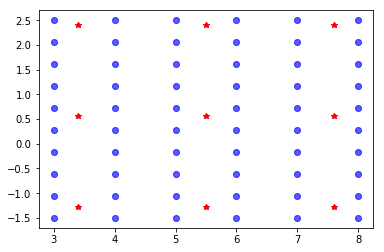

In [2]:
#Let's start with some small rectilinear grids for testing
#source grid 
src_lon_grid,src_lat_grid = generate_rect_test_grid(lons=3,lone=8,ni=5,lats=-1.5,late=2.5,nj=9)
#target grid
trg_lon_grid,trg_lat_grid = generate_rect_test_grid(3.4,7.6,2,-1.28,2.4,2)
plot_mesh_in_latlon(src_lon_grid, src_lat_grid, phi_color='bo', lam_color='bo',alpha=0.4)
plot_mesh_in_latlon(trg_lon_grid, trg_lat_grid, phi_color='r*', lam_color='r*')

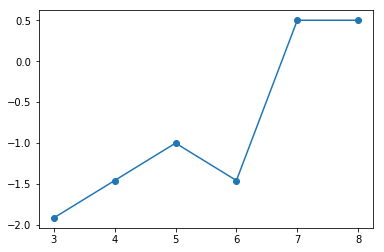

In [3]:
#Generate a fake source topography with a ridge in the middle
PI_180=np.pi/180
src_z = -1 - 1000*np.abs(np.sin((src_lon_grid-5) *PI_180) * np.sin((src_lat_grid-1.0) *PI_180))
#Add some positive height points as land
src_z[9,5] = 0.5
src_z[9,4] = 0.5
src_z[8,4] = 0.5
src_z[8,5] = 0.5

#plt.pcolormesh(src_lon_grid[0,:],src_lat_grid[:,0],src_z); plt.colorbar(extend='both');
#plt.pcolormesh(src_z); plt.colorbar(extend='both');
plt.plot(src_lon_grid[0,:],src_z[-1,:], marker='o')

### GridMesh Class

### 3.1.1 Refine the target grid

### 3.1.2. Project source data (height) onto to the finest refined grid

#### Project nearest neighbor

In [4]:
import numpy as np

def is_source_uniform(xs,ys):
    """Returns True if the input grid is uniform and False otherwise"""
    delx = np.roll(xs,shift=-1, axis=1) - xs 
    delx = delx[:,:-1]
    dely = np.roll(ys,shift=-1, axis=0) - ys 
    dely = dely[:-1,:]
    return (np.all(np.isclose(delx, delx[0,0]))) and (np.all(np.isclose(dely, dely[0,0])))

def refine_loop(trg_lon_grid,trg_lat_grid, src_lon_grid,src_lat_grid, max_stages=5):
    """This function refines the target grid until all points in the source grid are sampled."""
    """It returns the list of the refined grids."""
    GMesh_list = []    
    GMesh_list.append(GMesh(x=trg_lon_grid,y=trg_lat_grid))
    i=0
    hits = GMesh_list[i].source_hits(src_lon_grid,src_lat_grid)
    while(not np.all(hits) and i <= max_stages):
        print("Missed some! Must Refine! Stage ", i+1, "grid shape", GMesh_list[i].x.shape)
        GMesh_list.append(GMesh_list[i].refineby2())
        i=i+1
        hits = GMesh_list[i].source_hits(src_lon_grid,src_lat_grid)
        
    if(i > max_stages): 
        print("Warning: Maximum number of allowed refinements reached without all source points hit.")
    else:        
        print("Hit all! Done refining after ",i, " steps!")
        
    return GMesh_list, hits 

class GMesh:
    """Describes 2D meshes for ESMs.
    
    Meshes have shape=(nj,ni) cells with (nj+1,ni+1) vertices with coordinates (x,y).
    
    When constructing, either provide 1d or 2d coordinates (x,y), or assume a
    uniform spherical grid with 'shape' cells covering the whole sphere with
    longitudes starting at x0.
    
    Attributes:
    
    shape - (nj,ni)
    ni    - number of cells in x-direction (last)
    nj    - number of cells in y-direction (first)
    x     - longitude of mesh (cell corners), shape (nj+1,ni=1)
    y     - latitude of mesh (cell corners), shape (nj+1,ni=1)
    area  - area of cells, shape (nj,ni)
    """

    def __init__(self, shape=None, x=None, y=None, area=None, x0=-180., rfl=0):
        """Constructor for Mesh:
        shape - shape of cell array, (nj,ni)
        ni    - number of cells in x-direction (last index)
        nj    - number of cells in y-direction (first index)
        x     - longitude of mesh (cell corners) (1d or 2d)
        y     - latitude of mesh (cell corners) (1d or 2d)
        area  - area of cells (2d)
        x0    - used when generating a spherical grid in absence of (x,y)
        rfl   - refining level of this mesh
        """
        if (shape is None) and (x is None) and (y is None): raise Exception('Either shape must be specified or both x and y')
        if (x is None) and (y is not None): raise Exception('Either shape must be specified or both x and y')
        if (x is not None) and (y is None): raise Exception('Either shape must be specified or both x and y')
        # Determine shape
        if shape is not None:
            (nj,ni) = shape
        else: # Determine shape from x and y
            if (x is None) or (y is None): raise Exception('Either shape must be specified or both x and y')
            if len(x.shape)==1: ni = x.shape[0]-1
            elif len(x.shape)==2: ni = x.shape[1]-1
            else: raise Exception('x must be 1D or 2D.')
            if len(y.shape)==1 or len(y.shape)==2: nj = y.shape[0]-1
            else: raise Exception('y must be 1D or 2D.')
        self.ni = ni
        self.nj = nj
        self.shape = (nj,ni)
        # Check shape of arrays and construct 2d coordinates
        if x is not None and y is not None:
            if len(x.shape)==1:
                if len(y.shape)>1: raise Exception('x and y must either be both 1d or both 2d')
                if x.shape[0] != ni+1: raise Exception('x has the wrong length')
            if len(y.shape)==1:
                if len(x.shape)>1: raise Exception('x and y must either be both 1d or both 2d')
                if y.shape[0] != nj+1: raise Exception('y has the wrong length')
            if len(x.shape)==2 and len(y.shape)==2:
                if x.shape != y.shape: raise Exception('x and y are 2d and must be the same size')
                if x.shape != (nj+1,ni+1): raise Exception('x has the wrong size')
                self.x = x
                self.y = y
            else:
                self.x, self.y = np.meshgrid(x,y)
        else: # Construct coordinates
            y1d = np.linspace(-90.,90.,nj+1)
            x1d = np.linspace(x0,x0+360.,ni+1)
            self.x, self.y = np.meshgrid(x1d,y1d)
        if area is not None:
            if area.shape != (nj,ni): raise Exception('area has the wrong shape or size')
            self.area = area
        else:
            self.area = None
        
        self.rfl = rfl #refining level

    def __repr__(self):
        return '<GMesh ni:%i nj:%i shape:(%i,%i)>'%(self.ni,self.nj,self.shape[0],self.shape[1])
    def __getitem__(self, key):
        return getattr(self, key)

    def dump(self):
        print(self)
        print('x.rfl   =',self.rfl)
        print('x.shape =',self.x.shape)
        print('y.shape =',self.y.shape)
        print('h.shape =',self.height.shape)

    def refineby2(self):
        """Returns new Mesh instance with twice the resolution"""
        x = np.zeros( (2*self.nj+1, 2*self.ni+1) )
        y = np.zeros( (2*self.nj+1, 2*self.ni+1) )
        #area = numpy.zeros( (2*self.nj, 2*self.ni) )
        x[::2,::2] = self.x
        x[::2,1::2] = 0.5 * ( self.x[:,:-1] + self.x[:,1:] )
        x[1::2,::2] = 0.5 * ( self.x[:-1,:] + self.x[1:,:] )
        x[1::2,1::2] = 0.25 * ( ( self.x[:-1,:-1] + self.x[1:,1:] ) + ( self.x[:-1,1:] + self.x[1:,:-1] ) )
        y[::2,::2] = self.y
        y[::2,1::2] = 0.5 * ( self.y[:,:-1] + self.y[:,1:] )
        y[1::2,::2] = 0.5 * ( self.y[:-1,:] + self.y[1:,:] )
        y[1::2,1::2] = 0.25 * ( ( self.y[:-1,:-1] + self.y[1:,1:] ) + ( self.y[:-1,1:] + self.y[1:,:-1] ) )
        return GMesh(x=x, y=y, rfl=self.rfl+1)
        
    def coarsenby2(self, coarser_mesh):
        """Set the height for lower level Mesh by coarsening"""
        if(self.rfl == 0): 
            raise Exception('Coarsest grid, no more coarsening possible!')
 
        coarser_mesh.height = self.height[::2,::2]
#        coarser_mesh.height[:-1,:-1] = 0.5*(coarser_mesh.height[:-1,:-1]+self.height[1::2,1::2])
        coarser_mesh.height[:-1,:-1] = 0.25*(coarser_mesh.height[:-1,:-1]
                                            + self.height[1::2,1::2]
                                            + self.height[1:-1:2,0:-1:2]
                                            + self.height[0:-1:2,1:-1:2])


    def find_nn_uniform_source(self,xs,ys):
        """Returns the i&j arrays for the indexes of the nearest neighbor point to each mesh point"""
        #Here we assume that the source mesh {(xs,ys)} is a uniform lat-lon mesh!
        #In this case the index of the closest source point can be easily found by arithmetic.          
        if (not is_source_uniform(xs,ys)): raise Exception('source grid is not uniform, this method will not work properly')
        delxs = xs[0,1] - xs[0,0]
        delys = ys[1,0] - ys[0,0]        
#        nn_i = np.rint((self.x-xs[0,0])/delxs) #Nearest integer (the even one if equidistant)
#        nn_j = np.rint((self.y-ys[0,0])/delys)   
        nn_i = np.floor(0.5+(self.x-xs[0,0])/delxs) #Nearest integer (the upper one if equidistant)
        nn_j = np.floor(0.5+(self.y-ys[0,0])/delys)  
        #These must be bounded by the extents of the arrays
        upper_i=xs.shape[1]-1
        upper_j=ys.shape[0]-1
        nn_i = np.where(nn_i>upper_i, upper_i, nn_i)
        nn_j = np.where(nn_j>upper_j, upper_j, nn_j)
        nn_i = np.where(nn_i<0, 0, nn_i)
        nn_j = np.where(nn_j<0, 0, nn_j)
        return nn_i.astype(int),nn_j.astype(int)
    
    def source_hits(self, xs, ys):
        """Returns the number of times each source data point is sampled by this mesh"""
        #This depends on the sampling method
        #Here we assume a Nearest Neighbor sampling. 
        #For each GMesh point (x,y):
        #   find the nearest point on the source mesh {(xs,ys)}
        #   increment the number of hits for that source point
        #
        if xs.shape != ys.shape: raise Exception('xs and ys must be the same shape')
        nns_i,nns_j = self.find_nn_uniform_source(xs,ys) 
        hits = np.zeros(xs.shape)
        hits[nns_j[:,:],nns_i[:,:]] = 1
#Niki: Deal with the degenerate cases where source points are well outside the target domain 
#      and are never going to be hit.
        return hits

#Niki: The following function can be combined with the above without much overhead to save an extra call
    def project_source_data_onto_target_mesh(self,xs,ys,zs):
        """Returns the array on target mesh with values equal to the nearest-neighbor source point data"""
        if xs.shape != ys.shape: raise Exception('xs and ys must be the same shape')
        nns_i,nns_j = self.find_nn_uniform_source(xs,ys) 
        self.height = np.zeros(self.x.shape)
        self.height[:,:] = zs[nns_j[:,:],nns_i[:,:]]
        return 

#Niki: We need an interface to return i,j for a given lat,lon


In [5]:
#import inspect
#import imp  
#import GMesh as gm

#Reload the GMesh tool (in case you change something in the tool and want it to take effect in this notebook)
#imp.reload(gm) 

#gm_source = inspect.getsource(gm)
#print(gm_source)

#refinedGMlist, hits = gm.refine_loop(trg_lon_grid,trg_lat_grid, src_lon_grid,src_lat_grid)
#refinedGMlist[-1].dump()


refinedGMlist, hits = refine_loop(trg_lon_grid,trg_lat_grid, src_lon_grid,src_lat_grid)

refinedGMlist[-1].project_source_data_onto_target_mesh(src_lon_grid,src_lat_grid,src_z)

refinedGMlist[-1].coarsenby2(refinedGMlist[-2])
refinedGMlist[-1].dump()
refinedGMlist[-2].dump()

#plt.pcolormesh(refinedGMlist[-2].x,refinedGMlist[-2].y, refinedGMlist[-2].height); plt.colorbar();  

refinedGMlist[-2].coarsenby2(refinedGMlist[-3])
refinedGMlist[-2].dump()
refinedGMlist[-3].dump()

#plt.pcolormesh(refinedGMlist[-3].x,refinedGMlist[-3].y, refinedGMlist[-3].height); plt.colorbar();  

refinedGMlist[-3].coarsenby2(refinedGMlist[-4])
refinedGMlist[-3].dump()
refinedGMlist[-4].dump()

#plt.pcolormesh(refinedGMlist[-4].x,refinedGMlist[-4].y, refinedGMlist[-4].height); plt.colorbar();  

Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
<GMesh ni:16 nj:16 shape:(16,16)>
x.rfl   = 3
x.shape = (17, 17)
y.shape = (17, 17)
h.shape = (17, 17)
<GMesh ni:8 nj:8 shape:(8,8)>
x.rfl   = 2
x.shape = (9, 9)
y.shape = (9, 9)
h.shape = (9, 9)
<GMesh ni:8 nj:8 shape:(8,8)>
x.rfl   = 2
x.shape = (9, 9)
y.shape = (9, 9)
h.shape = (9, 9)
<GMesh ni:4 nj:4 shape:(4,4)>
x.rfl   = 1
x.shape = (5, 5)
y.shape = (5, 5)
h.shape = (5, 5)
<GMesh ni:4 nj:4 shape:(4,4)>
x.rfl   = 1
x.shape = (5, 5)
y.shape = (5, 5)
h.shape = (5, 5)
<GMesh ni:2 nj:2 shape:(2,2)>
x.rfl   = 0
x.shape = (3, 3)
y.shape = (3, 3)
h.shape = (3, 3)


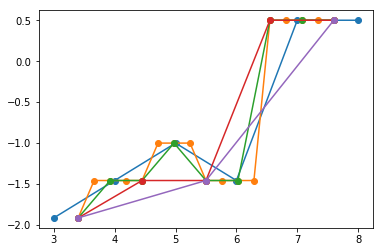

In [6]:
#plt.pcolormesh(refinedGMlist[-1].x,refinedGMlist[-1].y, refinedGMlist[-1].height); plt.colorbar();
plt.plot(src_lon_grid[0,:],src_z[-1,:], marker='o')
plt.plot(refinedGMlist[-1].x[-1,:],refinedGMlist[-1].height[-1,:], marker='o')
plt.plot(refinedGMlist[-2].x[-1,:],refinedGMlist[-2].height[-1,:], marker='o')
plt.plot(refinedGMlist[-3].x[-1,:],refinedGMlist[-3].height[-1,:], marker='o')
plt.plot(refinedGMlist[-4].x[-1,:],refinedGMlist[-4].height[-1,:], marker='o')

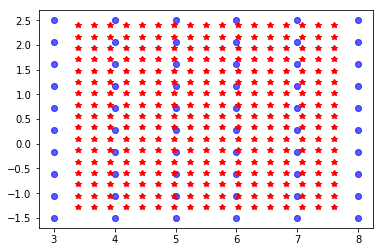

In [7]:
plot_mesh_in_latlon(src_lon_grid, src_lat_grid, phi_color='bo', lam_color='bo',alpha=0.4)
plot_mesh_in_latlon(refinedGMlist[-1].x,refinedGMlist[-1].y , phi_color='r*', lam_color='r*')

For each fine target cell assign 4 thin walls with heights equal to the interpolated value above.

In [8]:
a=np.zeros(2)
print(a,a.shape)

[ 0.  0.] (2,)


## Sand Box

### Target Model Grids

In [9]:
#Read in Mercator grid for 1/8 degree model
Merc_p125_grid =  netCDF4.Dataset('/net2/nnz/grid_generation/workdir/grid_OM4p125_new/tripolar_disp_res8.ncMerc.nc')
Merc_p125_lon = np.array(Merc_p125_grid.variables['x'])
Merc_p125_lat = np.array(Merc_p125_grid.variables['y'])
#print(Merc_p125_lon.shape,Merc_p125_lat.shape) #(2800, 5761) (2800, 5761)

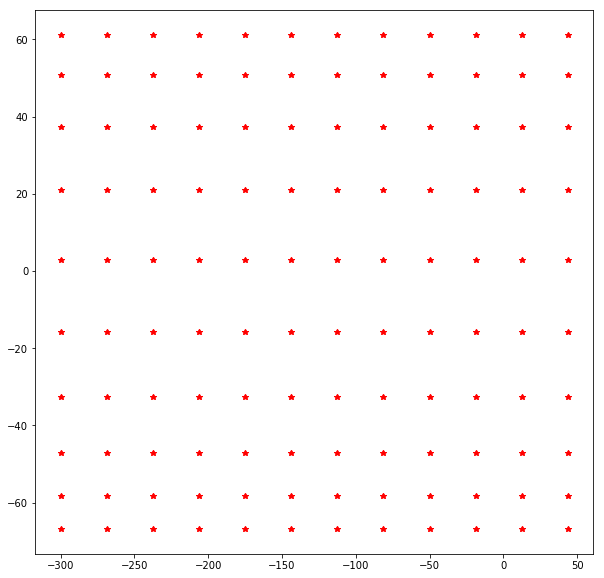

In [10]:
plt.figure(figsize=(10,10))
plot_mesh_in_latlon(Merc_p125_lon[::300,::500], Merc_p125_lat[::300,::500], phi_color='r*', lam_color='r*')
#plot_mesh_in_latlon(Merc_p125_lon, Merc_p125_lat, stride=60);


### GEBCO dataset

In [ ]:
#Global grid
#gebcodata = netCDF4.Dataset('/archive/gold/datasets/topography/GEBCO_08_v1.nc')
gebcodata = netCDF4.Dataset('/net2/nnz/thin-wall-topography/python/workdir/GEBCO_2014_2D.nc')
#gebcodata
#for var in gebcodata.variables :  print(var,end=' ') # elevation lat lon    
#Note that the variables are arrays but they are not numpy arrays. 
#Convert them to numpy using np.array so that they can be reshaped.
gebco_lon = np.array(gebcodata.variables['lon'])
gebco_lat = np.array(gebcodata.variables['lat'])
gebco_elv = np.array(gebcodata.variables['elevation'])
print('source grid array shapes: ' , gebco_lon.shape,gebco_lat.shape,gebco_elv.shape)
#source grid array shapes:  (43200,) (21600,) (21600, 43200)

gebco_lon_grd = np.tile(gebco_lon,(gebco_lat.shape[0],1))
gebco_lat_grd = np.tile(gebco_lat.reshape(gebco_lat.shape[0],1),(1,gebco_lon.shape[0]))
#print(gebco_lon_grd.shape,gebco_lat_grd.shape)
#(21600, 43200) (21600, 43200)
#plt.figure(figsize=(10,10))
#plt.pcolormesh(gebco_lon_grd[:,:], gebco_lat_grd[:,:],gebco_elv[:,:]);plt.colorbar();

#plot_mesh_in_latlon(gebco_lon_grd[::2000,::4000], gebco_lat_grd[::2000,::4000], phi_color='bo', lam_color='bo',alpha=0.4)

(2000, 2000)


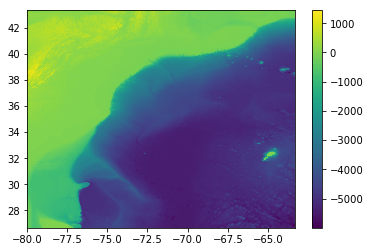

In [31]:
#pick a window
#ind_win = np.index_exp[10000:11800,21000:23200] #equatorial Atlantic
gebco_ind_win = np.index_exp[14000:16000,12000:14000]   
    
gebco_lon_grd1=gebco_lon_grd[gebco_ind_win]
gebco_lat_grd1=gebco_lat_grd[gebco_ind_win]
gebco_elv1    = gebco_elv[gebco_ind_win]
print(gebco_elv1.shape)
plt.pcolormesh(gebco_lon_grd1, gebco_lat_grd1,gebco_elv1);plt.colorbar();

tgt shape= (350, 280)
src shape= (2000, 2000)


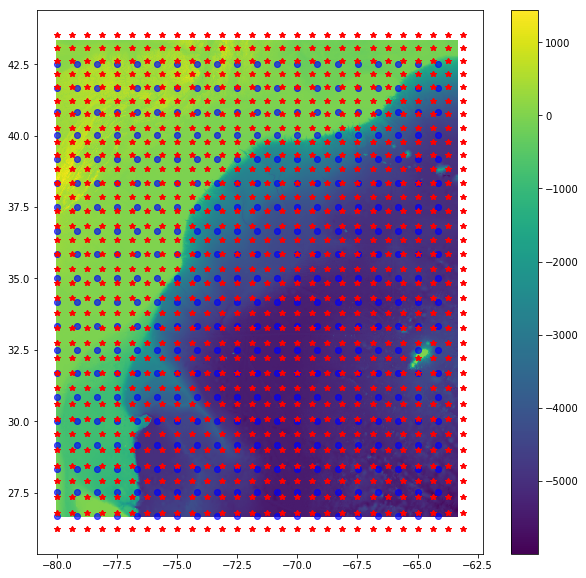

In [58]:
#For a given window in the target grid we must have a way to pick a window in the source grid so that 
#it is overlapped by the target grid such that it all its points are guaranteed to be sampled at least once in the
#refining algorithm.

Merc_ind_win  = np.index_exp[1890:2240,3520:3800]
Merc_p125_lon1 = Merc_p125_lon[Merc_ind_win] 
Merc_p125_lat1 = Merc_p125_lat[Merc_ind_win]
print("tgt shape=",Merc_p125_lon1.shape)

gebco_ind_win = np.index_exp[14000:16000,12000:14000]
gebco_lon_grd1=gebco_lon_grd[gebco_ind_win]
gebco_lat_grd1=gebco_lat_grd[gebco_ind_win]
gebco_elv1    = gebco_elv[gebco_ind_win]
print("src shape=", gebco_lon_grd1.shape)

plt.figure(figsize=(10,10))
plt.pcolormesh(gebco_lon_grd1, gebco_lat_grd1,gebco_elv1);plt.colorbar();

plot_mesh_in_latlon(gebco_lon_grd1[::100,::100], gebco_lat_grd1[::100,::100], phi_color='bo', lam_color='bo',alpha=0.4)
plot_mesh_in_latlon(Merc_p125_lon1[::10,::10], Merc_p125_lat1[::10,::10], phi_color='r*', lam_color='r*')



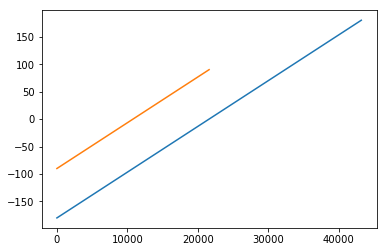

In [25]:
plt.plot(gebco_lon_grd[10800,:])
plt.plot(gebco_lat_grd[:,21600])

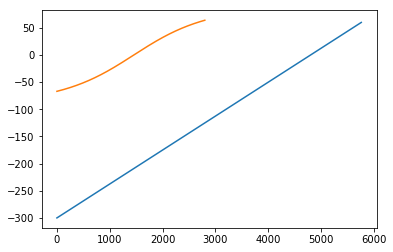

In [59]:
plt.plot(Merc_p125_lon[0,:])
plt.plot(Merc_p125_lat[:,0])

In [60]:
refinedGMlist_p125, hits_p125 = refine_loop(Merc_p125_lon1, Merc_p125_lat1, gebco_lon_grd1,gebco_lat_grd1)


Missed some! Must Refine! Stage  1 grid shape (350, 280)
Missed some! Must Refine! Stage  2 grid shape (699, 559)
Missed some! Must Refine! Stage  3 grid shape (1397, 1117)
Hit all! Done refining after  3  steps!


In [13]:
#Meditranian GEBCO grid
#gebcodataM = netCDF4.Dataset('http://thredds.socib.es/thredds/dodsC/ancillary_data/bathymetry/MED_GEBCO_30sec.nc')
gebcodata = netCDF4.Dataset('/net2/nnz/thin-wall-topography/python/workdir/MED_GEBCO_30sec.nc')
#gebcodata
#for var in gebcodata.variables :  print(var,end=' ')
#lat lon elevation     
#Note that the variables are arrays but they are not numpy arrays. 
#Convert them to numpy using np.array so that they can be reshaped.
gebcoM_lon = np.array(gebcodataM.variables['lon'])
gebcoM_lat = np.array(gebcodataM.variables['lat'])
gebcoM_elv = np.array(gebcodataM.variables['elevation'])
print('source grid array shapes: ' , gebcoM_lon.shape,gebcoM_lat.shape,gebcoM_elv.shape)
#source grid array shapes:  (6601,) (2162,) (2162, 6601)

#test a target grid
#plt.figure(figsize=(10,10))
#trg2_lon_grid,trg2_lat_grid = generate_rect_test_grid(-10.1,45.2,1000,29.,48.1,1000)
#plot_mesh_in_latlon(gebco_lon_grd[::100,::100], gebco_lat_grd[::100,::100], phi_color='bo', lam_color='bo',alpha=0.4)
#plot_mesh_in_latlon(trg2_lon_grid[::100,::100], trg2_lat_grid[::100,::100], phi_color='r*', lam_color='r*')

gebcoM_lon_grd = np.tile(gebcoM_lon,(gebcoM_lat.shape[0],1))
gebcoM_lat_grd = np.tile(gebcoM_lat.reshape(gebcoM_lat.shape[0],1),(1,gebcoM_lon.shape[0]))
#test a target grid
plt.figure(figsize=(10,10))
trgM_lon_grid,trgM_lat_grid = generate_rect_test_grid(-10.1,45.2,1000,29.,48.1,1000)
plot_mesh_in_latlon(gebcoM_lon_grd[::100,::100], gebcoM_lat_grd[::100,::100], phi_color='bo', lam_color='bo',alpha=0.4)
plot_mesh_in_latlon(trgM_lon_grid[::100,::100], trgM_lat_grid[::100,::100], phi_color='r*', lam_color='r*')

NameError: name 'gebcodataM' is not defined

In [ ]:
refinedGMlistM, hitsM = refine_loop(trgM_lon_grid,trgM_lat_grid, gebcoM_lon_grd,gebcoM_lat_grd)

In [ ]:
plt.figure(figsize=(10,10))
plot_mesh_in_latlon(gebcoM_lon_grd[::100,::100], gebcoM_lat_grd[::100,::100], phi_color='bo', lam_color='bo',alpha=0.4)
plot_mesh_in_latlon(refinedGMlistM[-1].x[::100,::100],refinedGMlistM[-1].y[::100,::100] , phi_color='r*', lam_color='r*')

In [ ]:
plt.pcolormesh(gebcoM_lon_grd[:,:], gebcoM_lat_grd[:,:],gebcoM_elv[:,:]);plt.colorbar();

In [ ]:
refinedGMlistM[-1].project_source_data_onto_target_mesh(gebcoM_lon_grd,gebcoM_lat_grd,gebcoM_elv)
plt.pcolormesh(refinedGMlistM[-1].x,refinedGMlistM[-1].y, refinedGMlistM[-1].height); plt.colorbar();    

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(gebcoM_lon_grd[0,::100],gebcoM_elv[1000,::100],marker='o',color='b')
plt.plot(refinedGMlistM[-1].x[0,::100],refinedGMlistM[-1].height[3909,::100],marker='o',color='r')

In [ ]:
print(refinedGMlistM[-1].x.shape)
print(refinedGMlistM[-1].height.shape)

print(gebcoM_lat_grd[1000,:])
#plt.plot(refinedGMlistM[-1].y[:,0])
print(refinedGMlistM[-1].y[3906:3909,0])
plt.plot(refinedGMlistM[-1].x[0,::100],refinedGMlistM[-1].height[3909,::100],marker='o')

In [ ]:
#My workstation runs out of its 65G memory  and starts swapping towards a crash at Stage 6
#We cannot keep the list of meshes and have to free up memory!!!
#refinedGMlist_2 = refine_loop(trg2_lon_grid,trg2_lat_grid, gebco_lon_grd,gebco_lat_grd)
#Missed some! Must Refine! Stage  1 grid shape (1001, 1001)
#Missed some! Must Refine! Stage  2 grid shape (2001, 2001)
#Missed some! Must Refine! Stage  3 grid shape (4001, 4001)
#Missed some! Must Refine! Stage  4 grid shape (8001, 8001)
#Missed some! Must Refine! Stage  5 grid shape (16001, 16001)
#Missed some! Must Refine! Stage  6 grid shape (32001, 32001)
#There was a bug causing this!! 
#Nevertheless, this might be a real issue in higher resolution.

In [ ]:
plt.pcolormesh(hits); plt.colorbar();

In [ ]:
a = np.array([0.1, 0.5, 0.9, 1.1, 1.5])
np.floor(a+0.5)

(21600, 43200) (2160, 4320, 10, 10)
(21600, 43200) (2160, 4320, 10, 10)


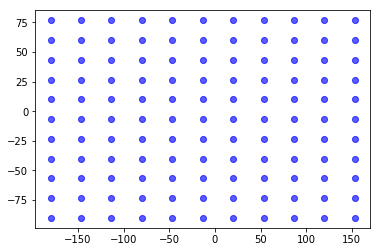

In [29]:
from numpy.lib.stride_tricks import as_strided
def block_view(A, block= (3, 3)):
    """Provide a 2D block view to 2D array. No error checking made.
    Therefore meaningful (as implemented) only for blocks strictly
    compatible with the shape of A."""
    # simple shape and strides computations may seem at first strange
    # unless one is able to recognize the 'tuple additions' involved ;-)
    shape= (A.shape[0]// block[0], A.shape[1]// block[1])+ block
    strides= (block[0]* A.strides[0], block[1]* A.strides[1])+ A.strides
    return as_strided(A, shape= shape, strides= strides)


gebco_lon_grd_block = block_view(gebco_lon_grd, block=(10,10))
print(gebco_lon_grd.shape,gebco_lon_grd_block.shape) #(21600, 43200) (2160, 4320, 10, 10)    
gebco_lat_grd_block = block_view(gebco_lat_grd, block=(10,10))
print(gebco_lat_grd.shape,gebco_lat_grd_block.shape) #(21600, 43200) (2160, 4320, 10, 10)    
plot_mesh_in_latlon(gebco_lon_grd_block[::200,::400,1,0], gebco_lat_grd_block[::200,::400,1,0], phi_color='bo', lam_color='bo',alpha=0.4)
#This is not what we want

In [33]:
#Applies a function to segments of an array
def segmented_process(M, blk_size=(16,16), overlap=(0,0), fun=None):
    rows = []
    for i in range(0, M.shape[0], blk_size[0]):
        cols = []
        for j in range(0, M.shape[1], blk_size[1]):
            cols.append(fun(M[i:i+blk_size[0], j:j+blk_size[1]]))
        rows.append(np.concatenate(cols, axis=1))
    return np.concatenate(rows, axis=0)

R = np.random.rand(128,128)
passthrough = lambda x:x
Rprime = segmented_process(R, blk_size=(16,16), 
                           overlap=(0,0), 
                           fun=passthrough)

print(R.shape,Rprime.shape)
np.all(R==Rprime)

(128, 128) (128, 128)


True

In [32]:
Rprime.shape

(128, 128)

In [17]:
def rolling_window(arr, window):
    """Very basic multi dimensional rolling window. window should be the shape of
    of the desired subarrays. Window is either a scalar or a tuple of same size
    as `arr.shape`.
    """
    shape = np.array(arr.shape*2)
    strides = np.array(arr.strides*2)
    window = np.asarray(window)
    shape[arr.ndim:] = window # new dimensions size
    shape[:arr.ndim] -= window - 1
    if np.any(shape < 1):
        raise ValueError('window size is too large')
    return np.lib.stride_tricks.as_strided(arr, shape=shape, strides=strides)

slices = rolling_window(gebco_lon_grd, (10,10))
slices.shape

(21591, 43191, 10, 10)

In [23]:
def split(array, nrows, ncols):
    """Split a matrix into sub-matrices."""

    r, h = array.shape
    return (array.reshape(h//nrows, nrows, -1, ncols)
                 .swapaxes(1, 2)
                 .reshape(-1, nrows, ncols))

a = split(gebco_lon_grd, 10,10)
a.shape

(9331200, 10, 10)

In [33]:
def cut_array2d(array, shape):
    arr_shape = np.shape(array)
    xcut = np.linspace(0,arr_shape[0],shape[0]+1).astype(np.int)
    ycut = np.linspace(0,arr_shape[1],shape[1]+1).astype(np.int)
    blocks = [];    xextent = [];    yextent = []
    for i in range(shape[0]):
        for j in range(shape[1]):
            blocks.append(array[xcut[i]:xcut[i+1],ycut[j]:ycut[j+1]])
            xextent.append([xcut[i],xcut[i+1]])
            yextent.append([ycut[j],ycut[j+1]])
    return xextent,yextent,blocks

x,y,blocks  = cut_array2d(gebco_lon_grd, (100,100))
print(x[0],y[0],blocks[0].shape)
print(x[-1],y[-1],blocks[-1].shape)

[0, 216] [0, 432] (216, 432)
[21384, 21600] [42768, 43200] (216, 432)


(21600, 4320) (21600, 4320)
-179.995833333 -144.004166667
144.004166667 179.995833333


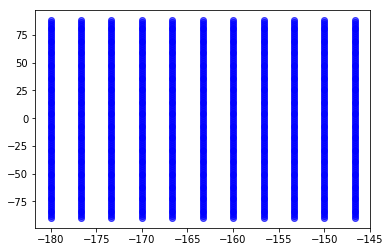

In [13]:
gebco_lon_grd_split = np.array_split(gebco_lon_grd,10,axis=1)
gebco_lat_grd_split = np.array_split(gebco_lat_grd,10,axis=1)
print(gebco_lon_grd_split[0].shape,gebco_lat_grd_split[0].shape)
print(gebco_lon_grd_split[0][0,0], gebco_lon_grd_split[0][0,-1])
print(gebco_lon_grd_split[-1][0,0], gebco_lon_grd_split[-1][0,-1])
#(21600, 4320) (21600, 4320)
#-179.995833333 -144.004166667
#144.004166667 179.995833333
#plot_mesh_in_latlon(gebco_lon_grd_split[0][::200,::400], gebco_lat_grd_split[0][::200,::400], phi_color='bo', lam_color='bo',alpha=0.4)



In [46]:
def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))

gebco_lon_grd_blk  = blockshaped(gebco_lon_grd, 216,432)
gebco_lat_grd_blk  = blockshaped(gebco_lat_grd, 216,432)
gebco_elv_blk      = blockshaped(gebco_elv,     216,432)
#gebco_lon_grd_blk.shape (10000, 216, 432)